<a href="https://colab.research.google.com/github/NastaCom/ML_for_business/blob/main/HW_3_GorokhovaA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?
6. (опциональный вопрос) Найти порог классификации по деньгам (Стоимость лечения 15000 р, если сделали тест и начали лечить вовремя. Стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы. Стоимость теста 1400 р)

### Определение сердечно-сосудистых заболевания

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,  mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

In [ ]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [ ]:
X_train.shape

(52500, 12)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [ ]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию 

#### Кроме 'Логистической регрессии' применю еще модели 'Случайный лес' и 'XGBoost' (по заданию)

In [ ]:
classifier_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C=100, random_state=42)),
])

classifier_ranforest = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)),
])

classifier_xgb = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(max_depth=3, n_estimators=100, random_state=42)),
])

#запустим кросс-валидацию
cv_scores_logreg = cross_val_score(classifier, X_train, y_train, cv=6, scoring='roc_auc')
cv_score_logreg = np.mean(cv_scores_logreg)
cv_score_std_logreg = np.std(cv_scores_logreg)
print('CV score model LogisticRegression is {}+-{}'.format(cv_score_logreg, cv_score_std_logreg))

cv_scores_ranforest = cross_val_score(classifier_ranforest, X_train, y_train, cv=6, scoring='roc_auc')
cv_score_ranforest = np.mean(cv_scores_ranforest)
cv_score_std_ranforest = np.std(cv_scores_ranforest)
print('CV score model RandomForestClassifier is {}+-{}'.format(cv_score_ranforest, cv_score_std_ranforest))

cv_scores_xgb = cross_val_score(classifier_xgb, X_train, y_train, cv=6, scoring='roc_auc')
cv_score_xgb = np.mean(cv_scores_xgb)
cv_score_std_xgb = np.std(cv_scores_xgb)
print('CV score model XGBClassifier is {}+-{}'.format(cv_score_xgb, cv_score_std_xgb))

CV score model LogisticRegression is 0.7868698300824125+-0.004835306405044692
CV score model RandomForestClassifier is 0.8003273839425447+-0.004144741871937934
[14:19:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:19:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:19:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:19:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:19:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:19:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV score model XGBClassifier is 0.8018166080947626+-0.0038197047666675764


#### По Roc AUC больше всего мне понравились показатели XGBoost

In [ ]:
#обучим пайплайн на всем тренировочном датасете
classifier_logreg.fit(X_train, y_train)
y_score_logreg = classifier_logreg.predict_proba(X_test)[:, 1]

In [ ]:
classifier_ranforest.fit(X_train, y_train)
y_score_ranforest = classifier_ranforest.predict_proba(X_test)[:, 1]

In [ ]:
classifier_xgb.fit(X_train, y_train)
y_score_xgb = classifier_xgb.predict_proba(X_test)[:, 1]

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Посчитаем precision/recall/f_score

In [ ]:
def metrics_calculation(y_test, preds, b=1):

    roc_auc = roc_auc_score(y_test, preds)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

In [ ]:
all_preds = [y_score_logreg, y_score_xgb, y_score_ranforest]
metrics = []
for preds in all_preds:
    best_threshold, fscore, precision, recall, roc_auc = metrics_calculation(y_test, preds)
    metrics.append([fscore, precision, recall, roc_auc])

In [ ]:
metrics_comparison_df = pd.DataFrame(np.array(metrics),
                   columns=['fscore', 'precision', 'recall', 'roc_auc'],
                   index=['y_score_logreg', 'y_score_ranforest', 'y_score_xgb'])
metrics_comparison_df

,fscore,precision,recall,roc_auc
y_score_logreg,0.730211,0.646980,0.838018,0.784256
y_score_ranforest,0.738862,0.690966,0.793894,0.802230
y_score_xgb,0.739811,0.697703,0.787327,0.800627


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

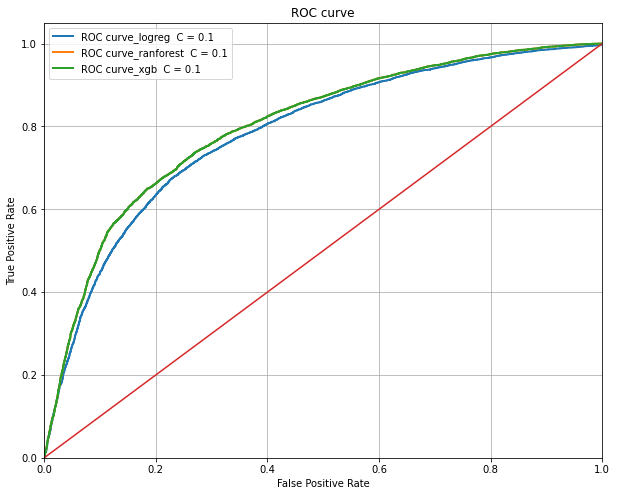

In [ ]:
#sns.set(font_scale=1.5)
#sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
#fpr3, tpr3, thresholds_ = roc_curve(y_test, y_score, pos_label=1)# C = 0.1
fpr1, tpr1, thresholds_ = roc_curve(y_test, y_score_logreg, pos_label=1)#C = 10
fpr2, tpr2, thresholds_ = roc_curve(y_test, y_score_ranforest, pos_label=1)
fpr3, tpr3, thresholds_ = roc_curve(y_test, y_score_xgb, pos_label=1)
lw = 2

plt.plot(fpr1, tpr1, lw=lw, label='ROC curve_logreg  C = 0.1')
plt.plot(fpr2, tpr2, lw=lw, label='ROC curve_ranforest  C = 0.1')
plt.plot(fpr2, tpr2, lw=lw, label='ROC curve_xgb  C = 0.1')

#plt.plot(fpr3, tpr3, lw=lw, label='ROC curve C = 10')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("ROC.png")
plt.grid()
plt.show()

#### Кривая XGBoost лучше )

#### Лучше других по метрикам fscore и roc_auc себя показала модель XGBoost, потом Случайный лес